In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random effects model

$y_{i,t} = \alpha_i + \beta_i x_{t-1,i} + \gamma_i w_{t-1} + \epsilon_{t,i}$

$\alpha_i = \alpha_0 + \eta_{\alpha_i}$

$\beta_i = \beta_0 + \eta_{\beta_i}$

$\gamma_i = \gamma_0 + \eta_{\gamma_i}$

$\alpha_0 \sim \mathcal{N}(0, \tau_\alpha)$

$\beta_0 \sim \mathcal{N}(0, \tau_\beta)$

$\gamma_0 \sim \mathcal{N}(0, \tau_\gamma)$

$\eta_{\alpha_i} \sim \mathcal{N}(0, \tau_{\eta_\alpha})$

$\eta_{\beta_i} \sim \mathcal{N}(0, \tau_{\eta_\beta})$

$\eta_{\gamma_i} \sim \mathcal{N}(0, \tau_{\eta_\gamma})$

$\tau_\alpha, \tau_\beta, \tau_\gamma, \tau_{\eta_\alpha}, \tau_{\eta_\beta}, \tau_{\eta_\gamma} \sim \Gamma(1,1)$

In [2]:
import pandas as pd
from seminartools.data import read_inflation, read_merged

In [3]:
df = read_merged().reset_index()
df

c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:161: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").apply(lambda x: (1 + x).prod() - 1)  # quarterly return
c:\users\vandi\onedrive\documenten\github\seminar\seminartools\data.py:397: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.resample("Q").mean()  # Mean interest rate


,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [4]:
from seminartools.models.random_effects_model import RandomEffectsModel

model = RandomEffectsModel()
model

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
model.formula

'inflation ~ (1 | country) + (0 + inflation_lag_1 | country)'

In [6]:
df

,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [7]:
model.fit(df)

In [8]:
import arviz as az

az.summary(model.results.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
inflation_sigma_log__,-0.198,0.015,-0.228,-0.169,0.000,0.000,8519.0,4356.0,1.00
Intercept,-0.018,0.117,-0.230,0.210,0.004,0.003,766.0,1116.0,1.00
1|country_sigma_log__,-0.720,0.186,-1.073,-0.382,0.005,0.004,1245.0,1929.0,1.00
inflation_lag_1|country_sigma_log__,-0.920,0.178,-1.255,-0.595,0.006,0.004,839.0,1449.0,1.01
inflation_sigma,0.821,0.013,0.797,0.844,0.000,0.000,8519.0,4356.0,1.00
1|country_sigma,0.495,0.094,0.336,0.672,0.003,0.002,1245.0,1929.0,1.00
inflation_lag_1|country_sigma,0.405,0.074,0.279,0.544,0.003,0.002,839.0,1449.0,1.01
1|country[Australia],0.171,0.132,-0.093,0.407,0.004,0.003,984.0,1613.0,1.00
1|country[Belgium],-0.057,0.141,-0.305,0.218,0.004,0.003,1050.0,2040.0,1.00
1|country[Canada],0.078,0.130,-0.175,0.315,0.004,0.003,916.0,1524.0,1.00


In [17]:
import seaborn as sns
preds = model.predict(df)

preds

<xarray.DataArray 'inflation_mean' (inflation_obs: 2095)> Size: 17kB
array([ 1.3023446 , -0.02323053,  0.79192   , ...,  0.92908163,
       -0.67014483, -0.13083265])
Coordinates:
  * inflation_obs  (inflation_obs) int32 8kB 0 1 2 3 4 ... 2091 2092 2093 2094


,date,country,inflation
0,2023-04-01,Australia,0.015333
1,2023-04-01,Belgium,0.016745
2,2023-04-01,Canada,0.006636
3,2023-04-01,Denmark,0.007396
4,2023-04-01,France,0.005557
5,2023-04-01,Germany,0.011341
6,2023-04-01,Italy,0.022287
7,2023-04-01,Japan,0.004870
8,2023-04-01,Korea,0.006032
9,2023-04-01,Netherlands,0.008437


Density predictions of the Random Effects model

In [24]:
preds = model.predict(df, "distribution")
preds

,date,country,inflation
0,2023-04-01,Australia,"{'pdf': [0.019502493504152733, 0.0201901229723..."
1,2023-04-01,Belgium,"{'pdf': [0.013495694284733444, 0.0139542180572..."
2,2023-04-01,Canada,"{'pdf': [0.005889599450553638, 0.0058856654203..."
3,2023-04-01,Denmark,"{'pdf': [0.0033286231375410868, 0.003328672771..."
4,2023-04-01,France,"{'pdf': [0.007662496475613731, 0.0078843449645..."
5,2023-04-01,Germany,"{'pdf': [0.005830541738222915, 0.0060355295669..."
6,2023-04-01,Italy,"{'pdf': [0.0024885702477699164, 0.002534951740..."
7,2023-04-01,Japan,"{'pdf': [0.007357117594040695, 0.0074399677892..."
8,2023-04-01,Korea,"{'pdf': [0.004217217773311883, 0.0042127276558..."
9,2023-04-01,Netherlands,"{'pdf': [0.016173911484947748, 0.0169050030199..."


0.003369948047493915
0.007999433635147987


Text(0.5, 1.0, 'Density United States')

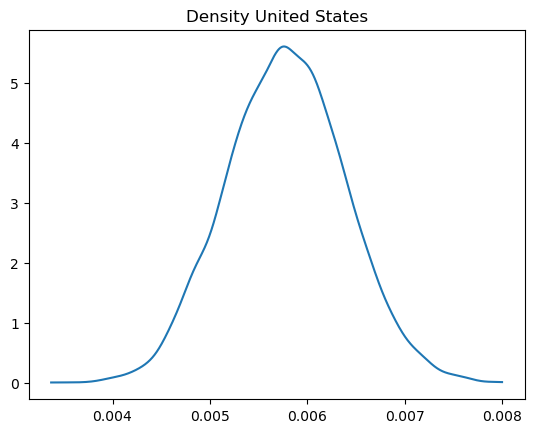

In [27]:
import matplotlib.pyplot as plt
import numpy as np

country = preds.iloc[-1]["country"]
density = preds.iloc[-1]["inflation"]

x_axis = density["inflation_grid"]
print(min(x_axis))
print(max(x_axis))
density_values = density["pdf"]

plt.plot(
    x_axis,
    density_values,
    )
plt.title(f"Density {country}")